In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import pymc3 as pm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

iris = pd.read_csv('input/iris-data.csv')
df=iris.replace({'target': {'setosa': 1}})
df=df.replace({'target': {'versicolor': 2}})
df=df.replace({'target': {'virginica': 3}})

データ（iris-data）のうちpetal length（花弁の長さ）がアヤメの種類の特徴をよく表している


→petal lengthにガウス混合モデルを適用しクラスタリングを行う

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


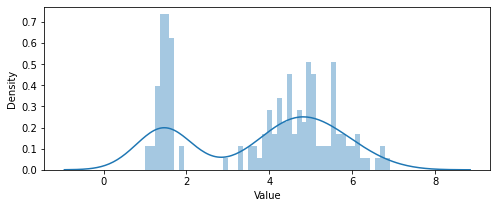

In [ ]:
x = df.iloc[:,2] 
K =3 #クラスタ数
l_1d = x.values.tolist()
l_1d
N = len(l_1d) #観測データ数
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)
ax.set_xlabel("Value")
sns.distplot(l_1d, bins=50, ax=ax)

In [ ]:
# 各確率変数の確率分布の定義
with pm.Model() as model:
  mu = pm.Normal('mu', mu=[1.5,4.5,5.7], sigma=1.2, shape=K) #平均はガウス分布
  tau = pm.Gamma('tau', alpha=10, beta=5, shape=K) #精度はガンマ分布
  pi = pm.Dirichlet('pi', a=np.ones(K), shape=K) #混合比率はディリクレ分布
  category = pm.Categorical('category', p=pi, shape=N) #クラスタ割り当てのパラメータはカテゴリカル分布
  x_var = pm.Normal('x', mu=mu[category], tau=tau[category], observed=l_1d) #xはガウス分布

ギブスサンプリングで、潜在変数 $\mathbf{s}_{n}$ のサンプリングと、 パラメータ $\mu_{k}, \lambda_{k \prime} \pi$ のサンプリングを交互に行う
$$
\begin{gathered}
\mu_{k}, \lambda_{k} \sim \mathcal{N}\left(\mu_{k} \mid m,\left(\beta \lambda_{k}\right)^{-1}\right) \operatorname{Gam}\left(\lambda_{k} \mid a, b\right) \\
\pi \sim \operatorname{Dir}(\pi \mid \alpha) \\
\mathbf{s}_{n} \sim \operatorname{Cat}\left(\mathbf{s}_{n} \mid \boldsymbol{\pi}\right) \\
x_{n} \sim \prod_{k=1}^{K} \mathcal{N}\left(x_{n} \mid \mu_{k}, \lambda_{k}^{-1}\right)^{s_{n, k}}
\end{gathered}
$$

In [ ]:
# ギブスサンプリングによるパラメータ推論 
with model:
    step1 = pm.Metropolis(vars=[mu, tau, pi])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
    idata = pm.sample(10000, step=[step1, step2], tune=5000)

INFO:/usr/local/lib/python3.7/dist-packages/theano/link/c/lazylinker_c.py:Compiling new CVM
INFO:/usr/local/lib/python3.7/dist-packages/theano/link/c/lazylinker_c.py:New version 0.211
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
INFO:pymc3:Sequential sampling (2 chains in 1 job)
INFO:pymc3:CompoundStep
INFO:pymc3:>CompoundStep
INFO:pymc3:>>Metropolis: [pi]
INFO:pymc3:>>Metropolis: [tau]
INFO:pymc3:>>Metropolis: [mu]
INFO:pymc3:>ElemwiseCategorical: [category]


INFO:pymc3:Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 154 seconds.
/usr/local/lib/python3.7/dist-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f40b16c99d0>,
      dtype=object)

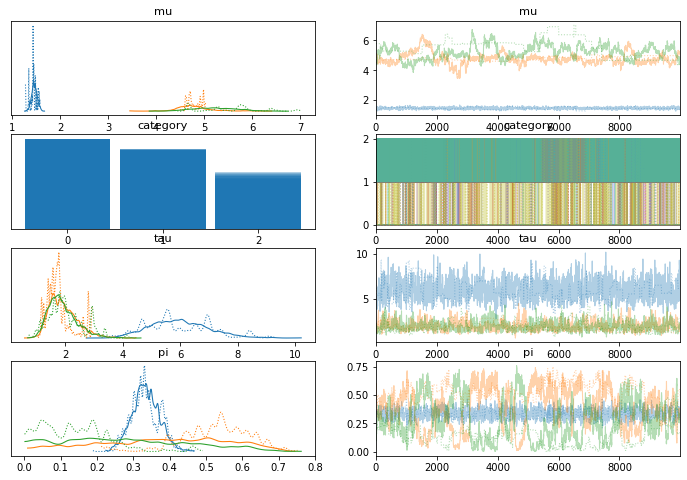

In [ ]:
pm.plot_trace(idata) #各パラメータの事後分布の描画

In [ ]:
print(idata['mu'].mean(axis = 0))

[1.45612285 4.78924212 5.36875296]


In [ ]:
print(idata['tau'].mean(axis = 0))

[5.96046356 1.85151263 1.96482265]


In [ ]:
print(idata['pi'].mean(axis = 0))

[0.33428312 0.4539845  0.21173238]


In [ ]:
# 所属クラスタのベイズ推論
def clustering(x, trace, n_sample = None):
    def likelihood(x, pi, mu, tau): 
      return pi * stats.norm.pdf(x, mu, 1./np.sqrt(tau)) 
    # 各パラメータの事後分布
    pi = trace['pi']
    mu = trace['mu']
    tau = trace['tau']
    slist = []
    if n_sample is None:
      n_sample = pi.shape[0] 
    for k in range(K): 
      s_k = list(map(lambda i:likelihood(x=x,pi=pi[i,k],mu=mu[i,k],tau=tau[i,k]),np.arange(n_sample))) 
      slist.append(s_k)
    #正規化
    slist = np.array(slist)
    nterm = slist.sum(axis=0) 
    p_k = (slist / nterm).T 
    return p_k

[array([9.99955885e-01, 1.81162097e-05, 2.59991067e-05]), array([9.99936319e-01, 2.73170824e-05, 3.63636998e-05]), array([9.99900981e-01, 4.45352869e-05, 5.44839054e-05]), array([9.99834277e-01, 7.83488658e-05, 8.73743279e-05]), array([9.99701485e-01, 1.48534541e-04, 1.49980825e-04]), array([9.99420967e-01, 3.03245290e-04, 2.75788190e-04]), array([9.98789353e-01, 6.66701286e-04, 5.43945270e-04]), array([0.99726904, 0.00157913, 0.00115183]), array([0.99335691, 0.00402875, 0.00261434]), array([0.98268657, 0.01102226, 0.00629117]), array([0.95284603, 0.03166877, 0.0154852 ]), array([0.87442985, 0.08931325, 0.03625691]), array([0.70786755, 0.21767078, 0.07446167]), array([0.46348092, 0.4108434 , 0.12567567]), array([0.23494258, 0.59291002, 0.1721474 ]), array([0.09363797, 0.70511036, 0.20125166]), array([0.03068258, 0.75547155, 0.21384587]), array([0.0088626 , 0.77399465, 0.21714274]), array([0.00240809, 0.78049394, 0.21709797]), array([6.37100484e-04, 7.82830168e-01, 2.16532732e-01]), arr

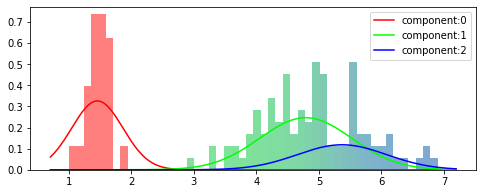

In [ ]:
# データの描画
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)
vals, bins, patches = ax.hist(x, bins=50, density=True, alpha=0.5) 

# ビン毎の所属クラスタの確率
cluster_list = list(map(lambda x:clustering(x, idata, n_sample=1000).mean(axis=0),bins[1:]))
print(cluster_list)
for i, p in enumerate(cluster_list): 
  patches[i].set_facecolor(p) #ビンに所属クラスタの色を描画

# 推論したパラメータの事後分布の平均を用いた所属クラスタの描画
xmin, xmax, ymin, ymax = ax.axis()
xl = np.linspace(xmin, xmax, 1000)
mpi = idata['pi'].mean(axis=0)
mmu = idata['mu'].mean(axis=0)
mtau = idata['tau'].mean(axis=0)
for k in range(K):
  pdf = mpi[k] * stats.norm(mmu[k], 1./np.sqrt(mtau[k])).pdf(xl)
  c = np.zeros(K)
  c[k] = 1
  ax.plot(xl, pdf, color=c, label='component:{}'.format(k))
ax.legend()